In [1]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot
from decimal import Decimal
from operator import add,sub
from scipy.optimize import LinearConstraint, BFGS, Bounds
import scipy as sp


In [2]:
ts_2=h5py.File('/media/zahra/DATA/example_7by7_lmax_mmax_250/draco_synthesis_nofluc/maps/tstream_2.h5','r')
ag_2=h5py.File('/media/zahra/DATA/example_7by7_lmax_mmax_250/draco_synthesis_nofluc/rand_gains/amp_phase/app_gain_2.h5','r')
rg_2=h5py.File('/media/zahra/DATA/example_7by7_lmax_mmax_250/draco_synthesis_nofluc/rand_gains/sig_2.h5','r')

gn_2=h5py.File('/media/zahra/DATA/example_7by7_lmax_mmax_250/draco_synthesis_nofluc/rand_gains/ts_final/app_gain_noise_2.h5','r')


In [3]:
m = manager.ProductManager.from_config('/media/zahra/DATA/example_7by7_lmax_mmax_250/prod_params_custom.yaml')

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/ex_3by3_dish_var/prod_params_custom.yaml')
#Scatterplot(m)

t=m.telescope
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]


#klobj=m.kltransforms['kl']

time_channel=400
Ndish=49
correlation_arr,sum_counts,corr_counts=Bls_counts(m)

Nbls,_=correlation_arr.shape

v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
vecs=1.e3*np.vstack([v1,v2])


lims=sum_counts
lims=np.append(0,sum_counts)

#lims=np.append(lims,lims)
#diag=sigma**2*np.ones(72)/1000


src=np.zeros(2*Nbls)
#src=1000*v1

ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)


Product directory: /media/zahra/DATA/example_7by7_lmax_mmax_250/bt_matrices


In [4]:
lims

array([   0,   42,   84,  120,  156,  191,  226,  256,  286,  316,  346,
        374,  402,  427,  452,  476,  500,  524,  548,  569,  590,  610,
        630,  650,  670,  688,  706,  724,  742,  758,  774,  789,  804,
        819,  834,  848,  862,  874,  886,  898,  910,  922,  934,  946,
        958,  968,  978,  988,  998, 1007, 1016, 1024, 1032, 1040, 1048,
       1055, 1062, 1068, 1074, 1080, 1086, 1092, 1098, 1104, 1110, 1115,
       1120, 1125, 1130, 1134, 1138, 1142, 1146, 1150, 1154, 1157, 1160,
       1163, 1166, 1168, 1170, 1172, 1174, 1175, 1176])

In [5]:
runs=1
random_pt1=np.load('random_pt1.npy')

def fit_gains(m,file_no_gain,gain, file_with_gain,file_gain_noise, time_channel,Tsys,ndays,random):
    gg=np.zeros((runs,Ndish*2))
    for run in range(runs):
        arr=Visibilities_grid(m,file_no_gain,gain,file_with_gain,file_gain_noise,time_channel,Tsys,ndays)
        vis=arr[2][:,time_channel]
        sigma=arr[-1]
        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        
        gain=gain['gain'][0,:Ndish,time_channel]
        sim_gains=np.append(gain.real,gain.imag)
        sim_gains=np.zeros(Ndish*2)
        sim_gains[0::2]=gain.real
        sim_gains[1::2]=gain.imag
        sim_gains_amp=sim_gains[0::2]
        sim_gains_phase=sim_gains[1::2]
         
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[run,:]=fit_gains_run
        
        gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
        gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
        rec_gains_amp=gain_mean[0::2]
        rec_gains_phase=gain_mean[1::2]
        gain_std_amp=gain_std[0::2]
        gain_std_phase=gain_std[1::2]

    return rec_gains_amp, sim_gains_amp, arr
    
    
rec_gains_amp_2, sim_gains_amp_2, arr_2=fit_gains(m,ts_2,rg_2,ag_2, gn_2,time_channel,50,1,random_pt1)



(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 1993.190200
         Iterations: 30
         Function evaluations: 90
         Gradient evaluations: 79


/home/zahra/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


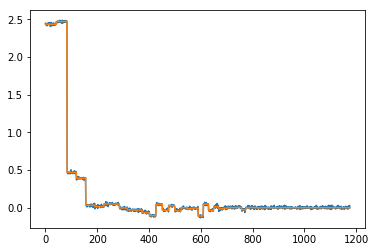

In [6]:
plt.plot(arr_2[2][:,time_channel])
plt.plot(arr_2[1][:,time_channel])
plt.show()

In [7]:
def rel_err(rec_gains_amp,sim_gains_amp):
    rel_err_amp=np.abs(rec_gains_amp-sim_gains_amp)/sim_gains_amp

    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rel_err_2=rel_err(rec_gains_amp_2,sim_gains_amp_2)

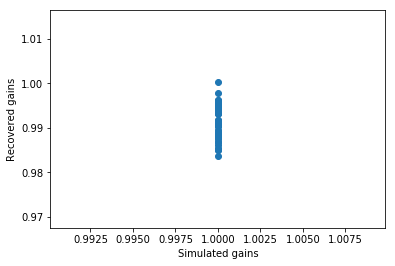

In [8]:
fig, ax = plt.subplots()
ax.scatter(sim_gains_amp_2, rec_gains_amp_2)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.9,1.025)
#plt.xlim(0.9,1.1)

In [9]:
print rec_gains_amp_2.min(), rec_gains_amp_2.max()

0.9835591508695071 1.000353605269865


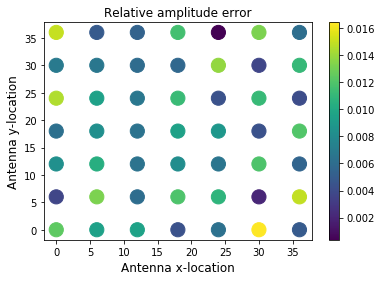

In [11]:
rel_err=np.abs(rec_gains_amp_2-sim_gains_amp_2)/sim_gains_amp_2

colour_scatterplot(m, rel_err)